In [71]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import scipy.spatial as sp
import torch.nn.functional as F
import seaborn as sns

In [5]:
sns.set(style='white', rc={'figure.figsize':(14,8)}) #24,8 for big one
plt.rcParams.update({'font.size': 42})

MICRO_SIZE = 14
SMALL_SIZE = 20
MEDIUM_SIZE = 26
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MICRO_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Dataset

In [7]:
#create custom dataset class

class MyDataset(Dataset):  
    def __init__(self, data, target, transform=None, flatten=False):
        if flatten:
            data = np.reshape(data, [-1, 28*28])
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
    
        if self.transform:
            x = self.transform(x)      
        return x,y
  
    def __len__(self):
        return len(self.data)

## Networks

In [8]:
class Network(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        
        self.hidden = nn.Linear(784, n_hidden)
        self.output = nn.Linear(n_hidden, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x) 
        return x

In [9]:
class NetworkConv(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_hidden, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2592, 10)
        self.softmax = nn.Softmax(dim=1)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2592)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

## Transforms

In [10]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [11]:
transform_noisy=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 1.)
])

In [12]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Diversification functions

In [13]:
# negative correlation for weights in layer

def div_nc(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.abs(torch.mean(((tensor_mean)**2 - (weights[i])**2)))
   
    loss = gamma*tensor_sum_nc
    return loss

In [14]:
#cosine similarity diversification (each with each - quadratic O)

def div_cosine(weights, gamma = 1):  
    tensor_sum = torch.zeros([len(weights[0])])
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):
        for j in range(len(weights)):
            tensor_sum_nc += torch.mean(F.cosine_similarity(weights[i],
                                                            weights[j],
                                                            0))
    
    loss = gamma*tensor_sum_nc
    return loss

In [15]:
#cosine similarity diversification (each with mean - linear O)

def div_cosine_lin(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.mean(F.cosine_similarity(tensor_mean,
                                                        weights[i],
                                                        0))
   
    loss = gamma*tensor_sum_nc
    return loss

In [16]:
def weight_criterion(weights, gamma = 1): #pass layer weights and gamma parameter here
    
    init_std = model.hidden.weight.std()
    init_mean = model.hidden.weight.mean()
    
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):
        for j in range(len(weights)):
            tensor_sum_nc += torch.mean(F.cosine_similarity(weights[i],
                                                            weights[j],
                                                            0))
   
    loss = (torch.abs(init_mean - weights.mean()) + torch.abs(init_std - weights.std()))*gamma*tensor_sum_nc
    return loss

### Test functions

In [17]:
model = Network(256).to(device)

In [18]:
modelConv = NetworkConv(16).to(device)

In [19]:
#DNN test
print(div_cosine(model.hidden.weight))
print(div_cosine_lin(model.hidden.weight))
print(div_nc(model.hidden.weight))

tensor(262.6736, grad_fn=<MulBackward0>)
tensor(16.2050, grad_fn=<MulBackward0>)
tensor(0.1081, grad_fn=<MulBackward0>)


In [20]:
#CNN test
print(div_cosine(modelConv.conv2.weight))
print(div_cosine_lin(modelConv.conv2.weight))
print(div_nc(modelConv.conv2.weight))

tensor(34.0363, grad_fn=<MulBackward0>)
tensor(5.7650, grad_fn=<MulBackward0>)
tensor(0.0711, grad_fn=<MulBackward0>)


# Train NN

In [45]:
def train(model, device, train_loader, optimizer, epoch, layer, gamma=1.0, diversity = "none"):
    model.train()
    train_loss = 0
    train_correct = 0
    # mean and standard deviation
    train_mean = 0
    train_std = 0
    #diversification and loss separately
    gamma_monitor = 0
    loss_monitor = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if epoch <= 5:
            loss = criterion(output, target)*0.0 + weight_criterion(layer, gamma=gamma)
        else:
            loss = criterion(output, target)
        #loss = conv_nc_2(model.hidden.weight, gamma)
        #print(model.hidden.weight.mean()*1000)
        train_mean += model.hidden.weight.mean()
        train_std += model.hidden.weight.std()
        gamma_monitor += div_nc(model.hidden.weight, gamma)
        loss_monitor += criterion(output, target)
        #print(conv_nc(model.output.weight, gamma))
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_mean /= len(train_loader.dataset)
    train_std /= len(train_loader.dataset)
    gamma_monitor /= len(train_loader.dataset)
    loss_monitor /= len(train_loader.dataset)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)
        )
    )

    return 100. * train_correct / len(train_loader.dataset), train_mean, train_std, gamma_monitor, loss_monitor

In [46]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
        )
    )

    return 100. * correct / len(test_loader.dataset), test_loss

## Train DNN (Fashion MNIST)

In [47]:
#download dataset from another library (keras)
from keras.datasets import mnist
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [48]:
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))/255
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))/255

In [49]:
train_dataset = MyDataset(x_train, y_train, transform=None, flatten=True)
train_loader = DataLoader(train_dataset, batch_size = 4096*4, shuffle=True)

test_dataset = MyDataset(x_test, y_test, transform=None, flatten=True)
test_loader = DataLoader(test_dataset, batch_size = 4096*4, shuffle=False)

In [53]:
gammas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 50
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  2

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  3

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  4

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  5

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  6

Train set: Average loss: 0.0002, Accuracy: 8642/60000 (14%)

Test set: Average loss: 0.0002, Accuracy: 2046/10000 (20%)

Epoch #:  7

Train set: Average loss: 0.0001, Accuracy: 12629/60000 (21%)

Test set: Average loss: 0.0002, Accuracy: 2309/10000 (23%)

Epoch #:  8

Train set: Average loss: 0.0001, Accuracy: 15094


Train set: Average loss: 0.0001, Accuracy: 36384/60000 (61%)

Test set: Average loss: 0.0002, Accuracy: 6226/10000 (62%)

Epoch #:  13

Train set: Average loss: 0.0001, Accuracy: 37822/60000 (63%)

Test set: Average loss: 0.0002, Accuracy: 6291/10000 (63%)

Epoch #:  14

Train set: Average loss: 0.0001, Accuracy: 38085/60000 (63%)

Test set: Average loss: 0.0002, Accuracy: 6327/10000 (63%)

Epoch #:  15

Train set: Average loss: 0.0001, Accuracy: 38198/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6342/10000 (63%)

Epoch #:  16

Train set: Average loss: 0.0001, Accuracy: 38284/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6354/10000 (64%)

Epoch #:  17

Train set: Average loss: 0.0001, Accuracy: 38364/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6367/10000 (64%)

Epoch #:  18

Train set: Average loss: 0.0001, Accuracy: 38444/60000 (64%)

Test set: Average loss: 0.0002, Accuracy: 6386/10000 (64%)

Epoch #:  19

Train set: Average loss: 0.0001, Accuracy: 3854


Train set: Average loss: 0.0001, Accuracy: 42779/60000 (71%)

Test set: Average loss: 0.0002, Accuracy: 7067/10000 (71%)

Epoch #:  24

Train set: Average loss: 0.0001, Accuracy: 42899/60000 (71%)

Test set: Average loss: 0.0002, Accuracy: 7096/10000 (71%)

Epoch #:  25

Train set: Average loss: 0.0001, Accuracy: 43027/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7102/10000 (71%)

Epoch #:  26

Train set: Average loss: 0.0001, Accuracy: 43130/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7112/10000 (71%)

Epoch #:  27

Train set: Average loss: 0.0001, Accuracy: 43221/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7124/10000 (71%)

Epoch #:  28

Train set: Average loss: 0.0001, Accuracy: 43301/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7136/10000 (71%)

Epoch #:  29

Train set: Average loss: 0.0001, Accuracy: 43346/60000 (72%)

Test set: Average loss: 0.0002, Accuracy: 7138/10000 (71%)

Epoch #:  30

Train set: Average loss: 0.0001, Accuracy: 4342


Train set: Average loss: 0.0001, Accuracy: 44129/60000 (74%)

Test set: Average loss: 0.0002, Accuracy: 7322/10000 (73%)

Epoch #:  35

Train set: Average loss: 0.0001, Accuracy: 44278/60000 (74%)

Test set: Average loss: 0.0002, Accuracy: 7332/10000 (73%)

Epoch #:  36

Train set: Average loss: 0.0001, Accuracy: 44419/60000 (74%)

Test set: Average loss: 0.0002, Accuracy: 7355/10000 (74%)

Epoch #:  37

Train set: Average loss: 0.0001, Accuracy: 44518/60000 (74%)

Test set: Average loss: 0.0002, Accuracy: 7362/10000 (74%)

Epoch #:  38

Train set: Average loss: 0.0001, Accuracy: 44618/60000 (74%)

Test set: Average loss: 0.0002, Accuracy: 7386/10000 (74%)

Epoch #:  39

Train set: Average loss: 0.0001, Accuracy: 44722/60000 (75%)

Test set: Average loss: 0.0002, Accuracy: 7387/10000 (74%)

Epoch #:  40

Train set: Average loss: 0.0001, Accuracy: 44767/60000 (75%)

Test set: Average loss: 0.0002, Accuracy: 7407/10000 (74%)

Epoch #:  41

Train set: Average loss: 0.0001, Accuracy: 4483

Test set: Average loss: 0.0002, Accuracy: 7215/10000 (72%)

Epoch #:  45

Train set: Average loss: 0.0001, Accuracy: 43926/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7215/10000 (72%)

Epoch #:  46

Train set: Average loss: 0.0001, Accuracy: 43957/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7213/10000 (72%)

Epoch #:  47

Train set: Average loss: 0.0001, Accuracy: 43969/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7211/10000 (72%)

Epoch #:  48

Train set: Average loss: 0.0001, Accuracy: 44002/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7217/10000 (72%)

Epoch #:  49

Train set: Average loss: 0.0001, Accuracy: 44016/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7225/10000 (72%)

Epoch #:  50

Train set: Average loss: 0.0001, Accuracy: 44054/60000 (73%)

Test set: Average loss: 0.0002, Accuracy: 7209/10000 (72%)

Epoch #:  1

Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/100


Train set: Average loss: 0.0000, Accuracy: 6000/60000 (10%)

Test set: Average loss: 0.0002, Accuracy: 1000/10000 (10%)

Epoch #:  6

Train set: Average loss: 0.0002, Accuracy: 13538/60000 (23%)

Test set: Average loss: 0.0002, Accuracy: 3535/10000 (35%)

Epoch #:  7

Train set: Average loss: 0.0001, Accuracy: 21990/60000 (37%)

Test set: Average loss: 0.0002, Accuracy: 4164/10000 (42%)

Epoch #:  8

Train set: Average loss: 0.0001, Accuracy: 26420/60000 (44%)

Test set: Average loss: 0.0002, Accuracy: 4743/10000 (47%)

Epoch #:  9

Train set: Average loss: 0.0001, Accuracy: 28843/60000 (48%)

Test set: Average loss: 0.0002, Accuracy: 4913/10000 (49%)

Epoch #:  10

Train set: Average loss: 0.0001, Accuracy: 29570/60000 (49%)

Test set: Average loss: 0.0002, Accuracy: 4965/10000 (50%)

Epoch #:  11

Train set: Average loss: 0.0001, Accuracy: 30420/60000 (51%)

Test set: Average loss: 0.0002, Accuracy: 5324/10000 (53%)

Epoch #:  12

Train set: Average loss: 0.0001, Accuracy: 32512/600

In [ ]:
#train_plots[3], train_plots[4] = train_plots[4], train_plots[3]

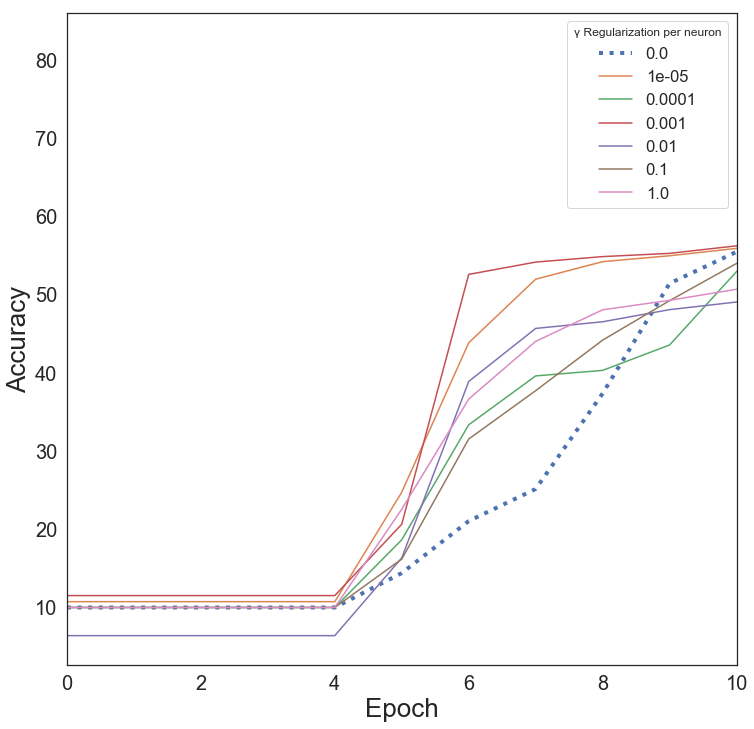

In [81]:
plt.figure(figsize=(12,12))
for i, tp in enumerate(train_plots):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
                   title = '\u03B3 Regularization per neuron',
                   fontsize='small',
                   fancybox=True)
#plt.title('Training Accuracy DNN 1Hidden256neurons, Negative Correlation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0,10)
plt.savefig("./figures_for_paper/weightPreInitalizeTrain.pdf")

In [84]:
for i, tp in enumerate(test_plots):
    print(gammas[i], np.round(np.mean(train_plots[i][4:10]), 2), np.round(np.mean(tp[4:10]), 2))

0.0 26.57 31.17
0.0001 40.09 43.46
0.001 30.92 34.55
0.01 41.52 47.01
0.1 33.66 37.3
1.0 31.48 35.59
10.0 35.1 38.87


(0, 10)

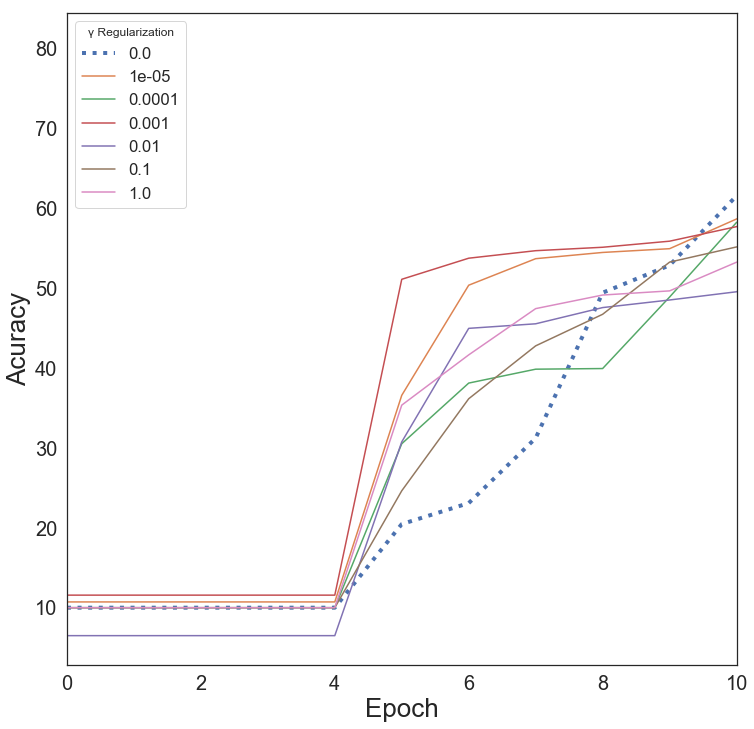

In [77]:
plt.figure(figsize=(12,12))
for i, tp in enumerate(test_plots):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
                   title = '\u03B3 Regularization',
                   fontsize='small',
                   fancybox=True)
#plt.title('Training Accuracy DNN 1Hidden256neurons, Negative Correlation')
plt.ylabel('Acuracy')
plt.xlabel('Epoch')
#plt.savefig("./figures_for_paper/TESTdnnFashionMnist64neurNc100e.pdf")
plt.xlim(0,10)
#plt.legend(handles=[one, two, three], title="title",
#                    loc=4, fontsize='small', fancybox=True)

(4, 10)

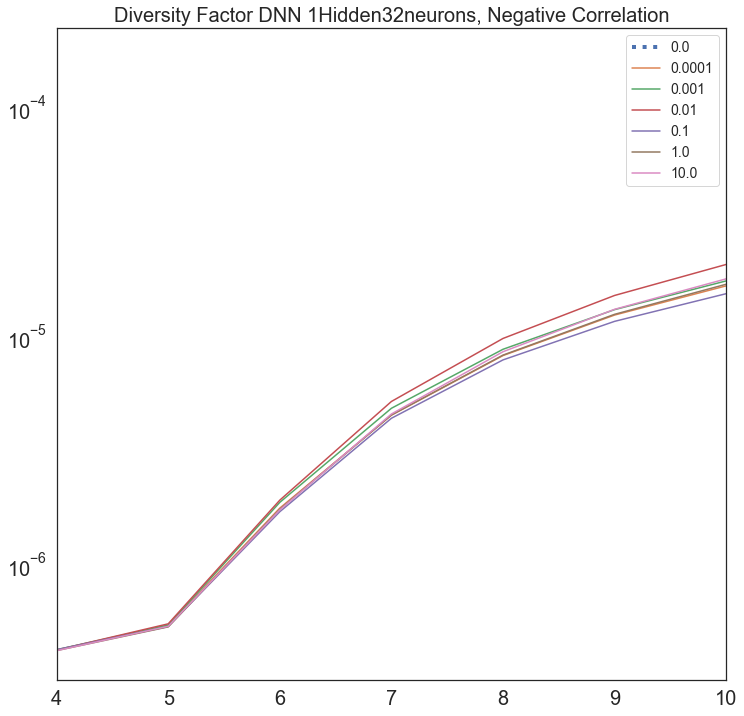

In [61]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(diversity[:n_pl]):
    if i == 0:
        plt.plot([p/gammas[i] for p in tp], linewidth=4, linestyle=':')
    else:
        plt.plot([p/gammas[i] for p in tp])
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
plt.title('Diversity Factor DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('Diversity_Factor_DNN_1Hidden32neurons_Negative Correlation.png')
plt.yscale('log') #
plt.xlim(4,10)

(0, 50)

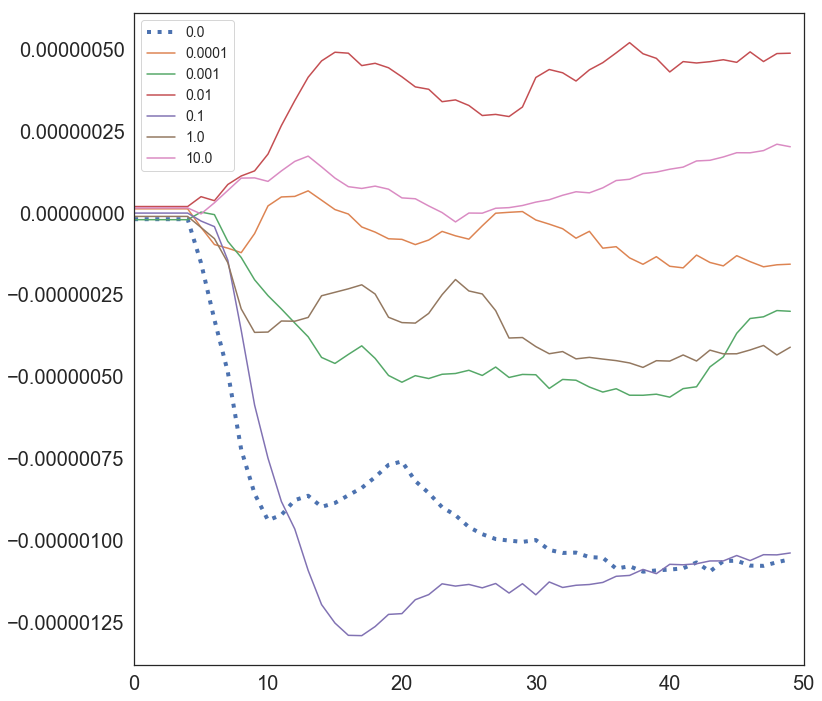

In [68]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(mean_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
#plt.title('Weight Mean DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('./figures/Weight_Mean_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #
plt.xlim(0,50)

(0, 10)

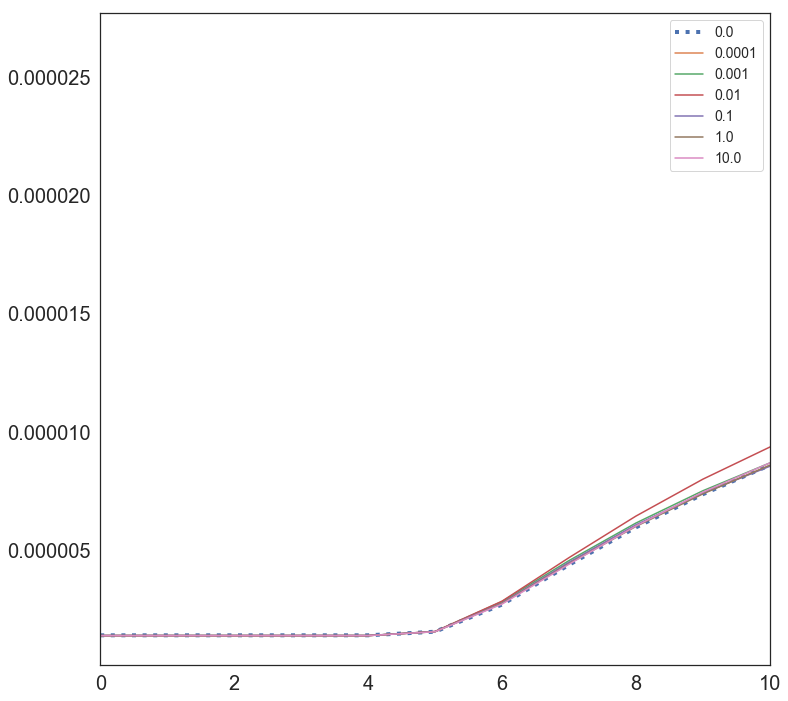

In [67]:
n_pl = 7#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(std_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
#plt.title('Standard Deviation DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('./figures/Standard_Deviation_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #
plt.xlim(0,10)

Text(0.5, 1.0, 'Train Loss DNN 1Hidden32neurons, Negative Correlation')

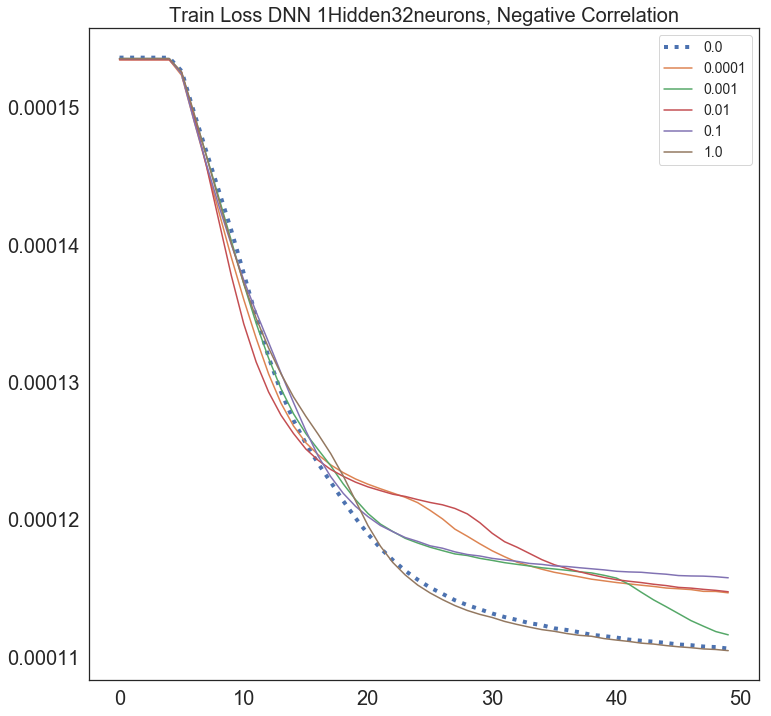

In [69]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for i, tp in enumerate(loss_train_all_gammas[:n_pl]):
    if i == 0:
        plt.plot(tp, linewidth=4, linestyle=':')
    else:
        plt.plot(tp)
        plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
plt.title('Train Loss DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('./figures/Train_Loss_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #

Text(0.5, 1.0, 'Test Loss DNN 1Hidden32neurons, Negative Correlation')

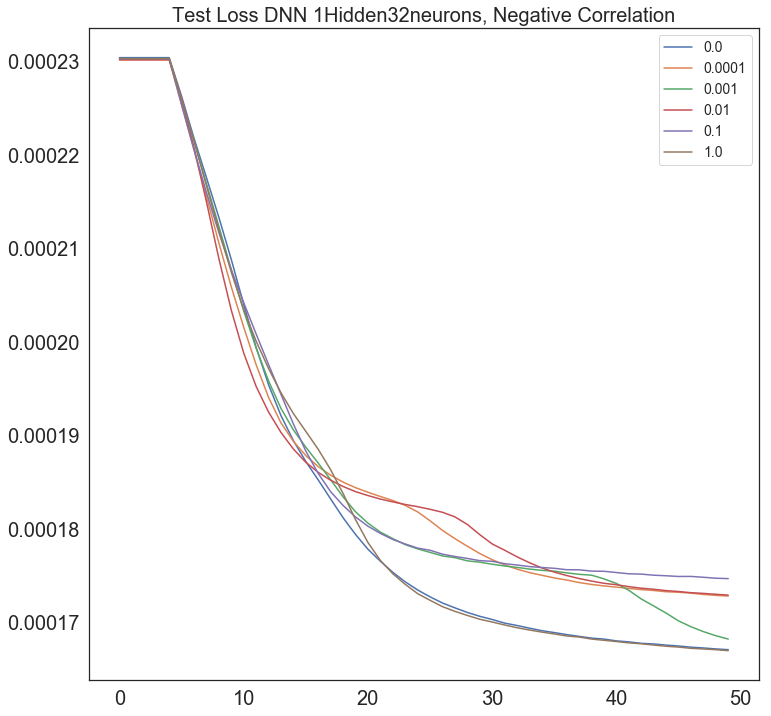

In [70]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Test Loss DNN 1Hidden32neurons, Negative Correlation')
#plt.savefig('./figures/Test_Loss_DNN_1Hidden32neurons_Negative_Correlation.png')
#plt.yscale('log') #

# Gradually Decrease Diversification